In [331]:
import tensorflow.keras as keras
import numpy as np
import matplotlib
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
# from RWNN import RWNNmodel

In [332]:
from tensorflow.python.eager import backprop
import tensorflow as tf
from tensorflow.python.eager import context
from tensorflow.python.framework import constant_op
from tensorflow.python.framework import dtypes
from tensorflow.python.framework import ops
from tensorflow.python.framework import tensor_shape
from tensorflow.python.keras import activations
from tensorflow.python.keras import backend as K
from tensorflow.python.keras import constraints
from tensorflow.python.keras import initializers
from tensorflow.python.keras import regularizers
from tensorflow.python.keras.engine.base_layer import Layer
from tensorflow.python.keras.engine.input_spec import InputSpec
from tensorflow.python.keras.utils import conv_utils
from tensorflow.python.keras.utils import generic_utils
from tensorflow.python.keras.utils import tf_utils
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import gen_math_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import nn
from tensorflow.python.ops import sparse_ops
from tensorflow.python.ops import standard_ops
from tensorflow.python.ops import variable_scope
from tensorflow.python.platform import tf_logging
from tensorflow.python.training.tracking import base as trackable
from tensorflow.python.util import nest
from tensorflow.python.util import tf_inspect
from tensorflow.python.util.tf_export import keras_export

class RWNN(Layer):
  def __init__(self,
               units,
               outunits,
               activation=None,
               kernel_initializer='glorot_uniform',
               kernel_regularizer=None,
               activity_regularizer=None,
               kernel_constraint=None,
               **kwargs):
    if 'input_shape' not in kwargs and 'input_dim' in kwargs:
      kwargs['input_shape'] = (kwargs.pop('input_dim'),)

    super(RWNN, self).__init__(
        activity_regularizer=regularizers.get(activity_regularizer), **kwargs)

    self.units = int(units) if not isinstance(units, int) else units
    self.outunits=outunits
               
    self.activation = activations.get(activation)
    self.use_bias = False
    self.kernel_initializer = initializers.get(kernel_initializer)
    self.kernel_regularizer = regularizers.get(kernel_regularizer)
    self.kernel_constraint = constraints.get(kernel_constraint)
    
    self.supports_masking = True
    self.input_spec = InputSpec(min_ndim=2)

  def build(self,input_shape):
    dtype = dtypes.as_dtype(self.dtype or K.floatx())
    self.inunits=input_shape[-1]
    self.kernel = self.add_weight(
        'kernel',
        shape=[self.units, self.units],
        initializer=self.kernel_initializer,
        regularizer=self.kernel_regularizer,
        constraint=self.kernel_constraint,
        dtype=self.dtype,
        trainable=True)
    self.built = True

  def call(self, inputs):
    print (inputs)
    inputs = math_ops.cast(inputs, self._compute_dtype)
    rank = len(inputs.shape)
    if inputs.shape[0] != None:
        z =tf.zeros((inputs.shape[0],self.units-self.inunits), dtype=tf.dtypes.float32, name=None)
    else:
        z =tf.zeros((1,self.units-self.inunits), dtype=tf.dtypes.float32, name=None)
    outputs = tf.concat([inputs, z], 1)
    for i in range(10):
#         print ("##########")
        outputs = gen_math_ops.mat_mul(outputs, self.kernel)
        if self.activation is not None:
            outputs=self.activation(outputs)
#         print (outputs)
        aux= tf.gather(outputs, [self.inunits + i for i in range(self.units-self.inunits)], axis=1)
#         print (aux)
        outputs=tf.concat([inputs, aux], 1)
#         print (outputs)
#         print ("##########")
    return tf.gather(outputs, [self.units-self.outunits + i for i in range(self.outunits)], axis=1)
    

  def compute_output_shape(self, input_shape):
    input_shape = tensor_shape.TensorShape(input_shape)
    input_shape = input_shape.with_rank_at_least(2)
    if tensor_shape.dimension_value(input_shape[-1]) is None:
      raise ValueError(
          'The innermost dimension of input_shape must be defined, but saw: %s'
          % input_shape)
    return input_shape[:-1].concatenate(self.outunits)
#     return self.outputs


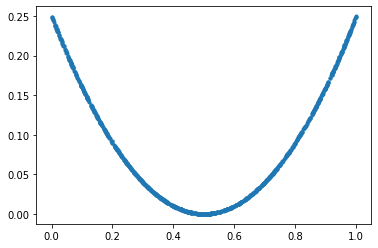

In [333]:
#1D
#simple 1d input -> 1d output training set (easy visualization)
seed=0
rng=np.random.RandomState(seed)
x=rng.rand(1000,1)
y=(x-0.5)**2
plt.plot(x,y,'.',)

In [322]:
init=keras.initializers.RandomUniform(minval=-1, maxval=1, seed=42)
a=RWNN(5,1, activation='sigmoid',kernel_initializer=init)
a.build((2,))
print (a.kernel)
i=tf.convert_to_tensor([[1,1],[2,2],[3,3]])
o=a.call(i)
print (o)
print (a.compute_output_shape(i.shape))


<tf.Variable 'kernel:0' shape=(5, 5) dtype=float32, numpy=
array([[-0.4351337 , -0.0031662 ,  0.43091702, -0.9595959 , -0.8428037 ],
       [ 0.25311875,  0.50999665, -0.6535883 , -0.7425747 , -0.89465904],
       [ 0.8850584 , -0.5390961 , -0.04491687, -0.5068898 ,  0.449152  ],
       [ 0.5381317 ,  0.07382178, -0.6625898 ,  0.0056169 , -0.6001148 ],
       [-0.92940617, -0.37443924, -0.05121136,  0.11959887,  0.64707446]],
      dtype=float32)>
tf.Tensor(
[[1 1]
 [2 2]
 [3 3]], shape=(3, 2), dtype=int32)
tf.Tensor(
[[0.18060322]
 [0.03569418]
 [0.00629923]], shape=(3, 1), dtype=float32)
(3, 1)


In [325]:
a=RWNN(5,1, activation='sigmoid',kernel_initializer=init)
a.build((1,))
a.call(x)

[[5.48813504e-01]
 [7.15189366e-01]
 [6.02763376e-01]
 [5.44883183e-01]
 [4.23654799e-01]
 [6.45894113e-01]
 [4.37587211e-01]
 [8.91773001e-01]
 [9.63662761e-01]
 [3.83441519e-01]
 [7.91725038e-01]
 [5.28894920e-01]
 [5.68044561e-01]
 [9.25596638e-01]
 [7.10360582e-02]
 [8.71292997e-02]
 [2.02183974e-02]
 [8.32619846e-01]
 [7.78156751e-01]
 [8.70012148e-01]
 [9.78618342e-01]
 [7.99158564e-01]
 [4.61479362e-01]
 [7.80529176e-01]
 [1.18274426e-01]
 [6.39921021e-01]
 [1.43353287e-01]
 [9.44668917e-01]
 [5.21848322e-01]
 [4.14661940e-01]
 [2.64555612e-01]
 [7.74233689e-01]
 [4.56150332e-01]
 [5.68433949e-01]
 [1.87898004e-02]
 [6.17635497e-01]
 [6.12095723e-01]
 [6.16933997e-01]
 [9.43748079e-01]
 [6.81820299e-01]
 [3.59507901e-01]
 [4.37031954e-01]
 [6.97631196e-01]
 [6.02254716e-02]
 [6.66766715e-01]
 [6.70637870e-01]
 [2.10382561e-01]
 [1.28926298e-01]
 [3.15428351e-01]
 [3.63710771e-01]
 [5.70196770e-01]
 [4.38601513e-01]
 [9.88373838e-01]
 [1.02044811e-01]
 [2.08876756e-01]
 [1.613095

<tf.Tensor: shape=(1000, 1), dtype=float32, numpy=
array([[0.3491207 ],
       [0.32065916],
       [0.33979157],
       [0.34980384],
       [0.37108755],
       [0.33240038],
       [0.36862165],
       [0.29156968],
       [0.28010538],
       [0.37823156],
       [0.3078972 ],
       [0.35258743],
       [0.34578493],
       [0.28614685],
       [0.4348069 ],
       [0.431856  ],
       [0.44414377],
       [0.30117282],
       [0.3101431 ],
       [0.29508507],
       [0.27775   ],
       [0.30666986],
       [0.36440438],
       [0.30974987],
       [0.42615405],
       [0.3334203 ],
       [0.42157182],
       [0.28311163],
       [0.35381663],
       [0.3726818 ],
       [0.39956018],
       [0.31079388],
       [0.36534375],
       [0.3457175 ],
       [0.44440663],
       [0.33723605],
       [0.33818713],
       [0.33735645],
       [0.28325778],
       [0.32629192],
       [0.3825013 ],
       [0.36871982],
       [0.323618  ],
       [0.43679082],
       [0.32884598],
    

Tensor("rwnn_147_input:0", shape=(None, 1), dtype=float32)
Model: "sequential_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rwnn_147 (RWNN)              (1, 10)                   2500      
_________________________________________________________________
dense_5 (Dense)              (1, 1)                    10        
Total params: 2,510
Trainable params: 2,510
Non-trainable params: 0
_________________________________________________________________
Train on 1000 samples
Epoch 1/80
Tensor("Cast:0", shape=(10, 1), dtype=float32)
Tensor("Cast:0", shape=(10, 1), dtype=float32)
1000/1000 [==============================] - 1s 1ms/sample - loss: 0.3152
Epoch 2/80
1000/1000 [==============================] - 0s 353us/sample - loss: 0.0030
Epoch 3/80
1000/1000 [==============================] - 0s 363us/sample - loss: 0.0023
Epoch 4/80
1000/1000 [==============================] - 1s 591us/sample - loss:

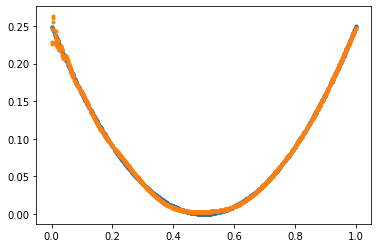

In [340]:
init=keras.initializers.RandomUniform(minval=-1, maxval=1, seed=42)

model = Sequential() 
model.add(RWNN(50,10, activation='tanh',input_shape=(1,),kernel_initializer=init))
model.add(Dense(1, activation='linear',use_bias=False,kernel_initializer=init))
          
model.summary()

opt=keras.optimizers.Adagrad(learning_rate=0.1)
model.compile(loss='mean_squared_error',
              optimizer=opt)


history = model.fit(x, y,
                    batch_size=10,
                    epochs=80,
                    verbose=1)
yy=model.predict(x,batch_size=len(x))
plt.plot(x,y,'.')
plt.plot(x,yy,'.')

In [306]:
# Print Weights 
for layer in model.layers:
    print(layer.get_weights())

[array([[-0.4351337 , -0.00865315,  0.38553542, ..., -1.0888232 ,
         0.5242967 , -1.5162641 ],
       [ 0.6249633 , -0.6162381 , -0.8451434 , ...,  0.6347467 ,
         0.14800614, -0.5653039 ],
       [-0.9514296 , -0.94429606, -0.6340952 , ..., -0.2747728 ,
         0.22581242,  0.20713973],
       ...,
       [ 0.38248086, -0.00849019, -0.7845906 , ..., -0.01813087,
         0.68706167, -0.31419292],
       [-0.8399899 , -0.26811272,  0.860927  , ...,  0.27483794,
         0.4043005 , -0.548418  ],
       [-0.5832453 ,  0.5635152 , -0.19924903, ...,  0.2402016 ,
        -0.35623783,  0.31046352]], dtype=float32)]


Tensor("rwnn_152_input:0", shape=(None, 1), dtype=float32)
Model: "sequential_54"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rwnn_152 (RWNN)              (1, 1)                    2500      
Total params: 2,500
Trainable params: 2,500
Non-trainable params: 0
_________________________________________________________________
Train on 1000 samples
Epoch 1/80
Tensor("Cast:0", shape=(10, 1), dtype=float32)
Tensor("Cast:0", shape=(10, 1), dtype=float32)
1000/1000 [==============================] - 1s 1ms/sample - loss: 0.5206
Epoch 2/80
1000/1000 [==============================] - 0s 317us/sample - loss: 0.0676
Epoch 3/80
1000/1000 [==============================] - 0s 313us/sample - loss: 0.0183
Epoch 4/80
1000/1000 [==============================] - 0s 307us/sample - loss: 0.0027
Epoch 5/80
1000/1000 [==============================] - 0s 359us/sample - loss: 0.0014
Epoch 6/80
1000/1000 [===============

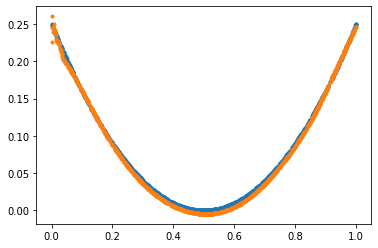

In [343]:
init=keras.initializers.RandomUniform(minval=-1, maxval=1, seed=42)

model = Sequential() 
model.add(RWNN(50,1, activation='tanh',input_shape=(1,),kernel_initializer=init))
          
model.summary()

opt=keras.optimizers.Adagrad(learning_rate=0.1)
model.compile(loss='mean_squared_error',
              optimizer=opt)


history = model.fit(x, y,
                    batch_size=10,
                    epochs=80,
                    verbose=1)
yy=model.predict(x,batch_size=len(x))
plt.plot(x,y,'.')
plt.plot(x,yy,'.')